In [1]:
import torch
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from transformers import BertConfig, BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

class NewsDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        model_name="bert-base-cased",
        split='train'
    ):
        self._device = "cuda:0" if torch.cuda.is_available() else "cpu"
        # self._config = BertConfig.from_pretrained(model_name)
        # self._bert_model = BertModel.from_pretrained(model_name, config=self._config)
        # self._bert_model.eval()
        # self._bert_tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
        self._bert_model = SentenceTransformer('all-mpnet-base-v2')
        self._data_df = pd.read_csv(f"../data/{split}_data.csv", index_col="Date")

    def __len__(self):
        return len(self._data_df.index)

    def __getitem__(self, index):
        row = self._data_df.iloc[index]
        label = row[-1]
        text_series = row[:-3]
        nan_count = text_series.isna().sum()
        day_text_matrix = np.empty((text_series.size - nan_count, 768))
        # self._bert_model = self._bert_model.to(self._device)
        for index, text in enumerate(text_series):
            if isinstance(text, str):
                # tokens = self._bert_tokenizer(text, return_tensors='pt')
                # output = self._bert_model(tokens.input_ids.to(self._device))
                # latent_matrix = output.last_hidden_state[0]
                # mean_vector = torch.mean(latent_matrix, 0)
                # mean_vector = mean_vector.to('cpu').detach().numpy()
                # mean_vector = mean_vector.reshape((1,-1))
                # day_text_matrix[index, :] = mean_vector
                sentences = [text]
                sentence_embeddings = self._bert_model.encode(sentences)
                day_text_matrix[index, :] = sentence_embeddings[0]
        return (
            torch.tensor(day_text_matrix),
            torch.tensor(label)
        )
        


[nltk_data] Downloading package punkt to /home/jorgenv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, device):
        super(Model, self).__init__()
        self.input_size = 768
        self.hidden_size = 384
        self.num_layers = 1
        self._device = device

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.7,
            batch_first=True
        )
        self.fc = nn.Linear(self.hidden_size, 1)

    def forward(self, x):
        h0, c0 = self.init_hidden(x.size(0))
        output, state = self.lstm(x, (h0, c0))
        output = self.fc(output[:, -1, :])
        output = torch.sigmoid(output)
        return output, state

    def init_hidden(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.hidden_size).to(self._device),
                torch.zeros(self.num_layers, sequence_length, self.hidden_size).to(self._device))

In [3]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

def train(train_dataset, val_dataset, model, device, batch_size=32, max_epochs=50):
    model.to(device)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
    )

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    results = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_accuracy": []
    }

    for epoch in range(max_epochs):
        results["epoch"].append(epoch)

        train_running_loss = []
        train_running_accuracy = []

        model = model.train()
        for _, (x, y_true) in enumerate(train_dataloader):
            optimizer.zero_grad()
            x = x.to(device)
            y_true = y_true.to(device)
            y_pred, _ = model(x.float())
            y_true = y_true.reshape((-1, 1))
            loss = criterion(y_pred, y_true.float())

            loss.backward()
            optimizer.step()

            train_running_loss.append(loss.item())

            pred = np.round(y_pred.cpu().detach())
            target = np.round(y_true.cpu().detach())
            accuracy = accuracy_score(target, pred)
            train_running_accuracy.append(accuracy)

        train_loss = np.mean(train_running_loss)
        results["train_loss"].append(train_loss)
        train_accuracy = np.mean(train_running_accuracy)
        results["train_accuracy"].append(train_accuracy)

        val_dataloader = DataLoader(
            val_dataset,
            batch_size=batch_size,
        )

        val_running_accuracy = []

        model = model.eval()
        with torch.no_grad():

            for _, (x, y_true) in enumerate(val_dataloader):
                x = x.to(device)
                y_true = y_true.to(device)
                y_pred, _ = model(x.float())
                y_true = y_true.reshape((-1, 1))

                pred = np.round(y_pred.cpu().detach())
                target = np.round(y_true.cpu().detach())
                accuracy = accuracy_score(target, pred)
                val_running_accuracy.append(accuracy)
        
        val_accuracy = np.mean(val_running_accuracy)
        results["val_accuracy"].append(val_accuracy)
        print({ 'epoch': epoch, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_accuracy': val_accuracy })

    return results
        


In [4]:
train_dataset = NewsDataset()
val_dataset = NewsDataset(split='val')
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = Model(device)

results = train(train_dataset, val_dataset, model, device)

/mnt/d/Code/UMBC_Capstone_2022/env/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


{'epoch': 0, 'train_loss': 0.7228601209141992, 'train_accuracy': 0.5121831293706294, 'val_accuracy': 0.5493055555555555}
{'epoch': 1, 'train_loss': 0.7047746791080995, 'train_accuracy': 0.5211975524475524, 'val_accuracy': 0.45069444444444445}
{'epoch': 2, 'train_loss': 0.7022573351860046, 'train_accuracy': 0.5126748251748251, 'val_accuracy': 0.45069444444444445}
{'epoch': 3, 'train_loss': 0.7023154402321036, 'train_accuracy': 0.5211975524475524, 'val_accuracy': 0.45069444444444445}
{'epoch': 4, 'train_loss': 0.7024213129823859, 'train_accuracy': 0.5211975524475524, 'val_accuracy': 0.45069444444444445}
{'epoch': 5, 'train_loss': 0.702100856737657, 'train_accuracy': 0.5204873251748251, 'val_accuracy': 0.45069444444444445}
{'epoch': 6, 'train_loss': 0.7017669623548334, 'train_accuracy': 0.5211975524475524, 'val_accuracy': 0.45069444444444445}
{'epoch': 7, 'train_loss': 0.7006086896766316, 'train_accuracy': 0.5247486888111887, 'val_accuracy': 0.45069444444444445}
{'epoch': 8, 'train_loss':

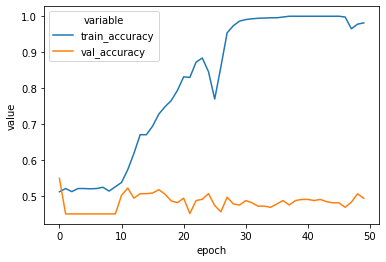

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results)
results_df = results_df.drop(columns=["train_loss"])
sns.lineplot(x="epoch", y="value", hue="variable", data=pd.melt(results_df, ["epoch"]))
plt.savefig('../plots/initial_train_2.png', dpi=300)

https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html

After training binary classification model, try having a tanh activation function as output. The output would be tanh but use a function to transform to logits: 

https://stats.stackexchange.com/a/221905
https://stackoverflow.com/questions/3985619/how-to-calculate-a-logistic-sigmoid-function-in-python/36440463#36440463